## Assignment 10
Members: Sayed Abid Hashimi, Harshit Juneja

In [5]:
import torch
from torchvision.datasets import StanfordCars, CelebA, Flowers102, MNIST
import matplotlib.pyplot as plt

In [142]:
# data = Flowers102(root='.', download=True)
data = MNIST(root='.', download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
def show_images(datset, num_samples=20, cols=4):
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

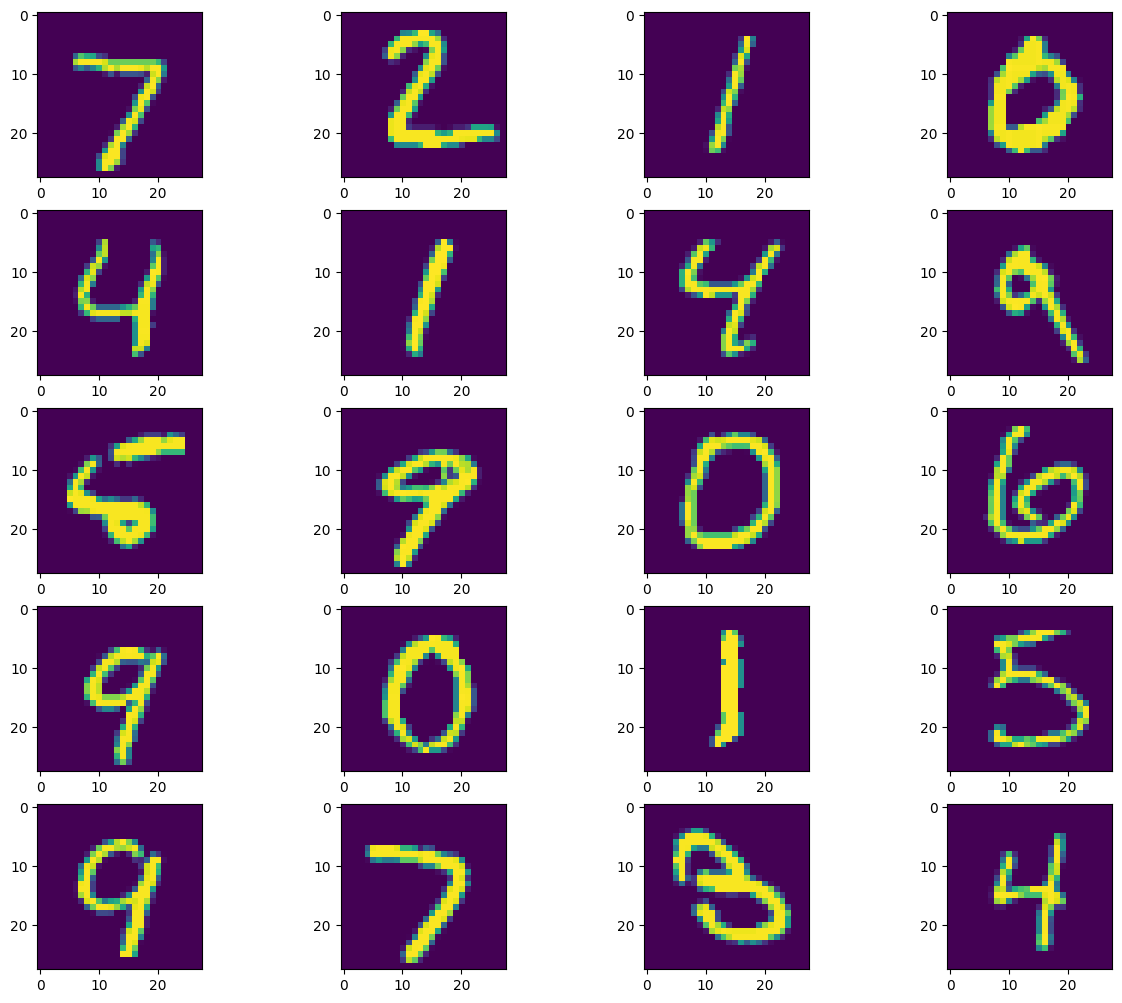

In [144]:
show_images(data)

In [36]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

In [37]:
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [39]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    data = MNIST(root=".", download=True, train=False, transform=data_transform)

    # test = Flowers102(root=".", download=True, 
    #                                      transform=data_transform, split='test')
    # return torch.utils.data.ConcatDataset([train, test])
    return data
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image), cmap="gray")

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/tmp/ipykernel_70458/1509478405.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


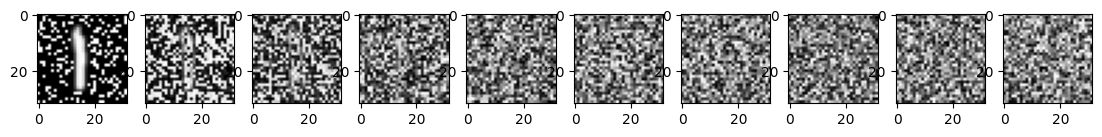

In [381]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

### UNet

In [40]:
from torch import nn
import math

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

        self.lable_embed = nn.Embedding(num_classes, time_emb_dim)

    def forward(self, x, timestep, y=None):
        t = self.time_mlp(timestep)

        if y is not None:
            t = t + self.lable_embed(y)
            
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [41]:
model = UNet(num_classes=10)
print("Num. Params: ", sum(param.numel() for param in model.parameters()))

Num. Params:  62437921


In [42]:
def get_loss(mode, x_0, t, y=None):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t, y)
    return F.l1_loss(noise, noise_pred)

In [52]:
@torch.no_grad()
def sample_timestep(x, t, label, cfg_scale):
    
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)


    cond = model(x, t, label)
    uncon = model(x, t, None)
    predicted_noise = (1 + cfg_scale) * cond - cfg_scale * uncon
    # predicted_noise =  model(x, t, label)
    # if cfg_scale > 0:
    #     unconditional_pred_noise = model(x, t, None)
    #     predicted_noise = torch.lerp(unconditional_pred_noise, predicted_noise, cfg_scale)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image(label, cfg_scale=3):
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 1, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, label, cfg_scale)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

Epoch 0 | step 000 Loss: 0.8054156303405762 Creating with Label : 2


/tmp/ipykernel_71272/3398544776.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


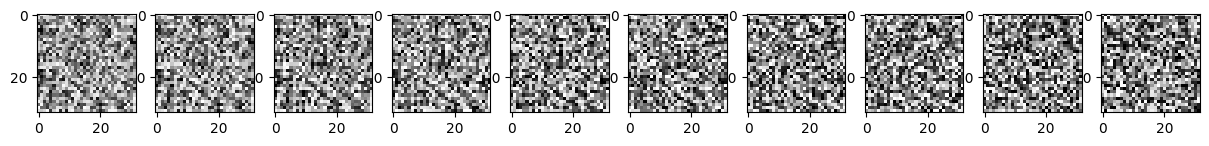

Epoch 5 | step 000 Loss: 0.10693903267383575 Creating with Label : 1


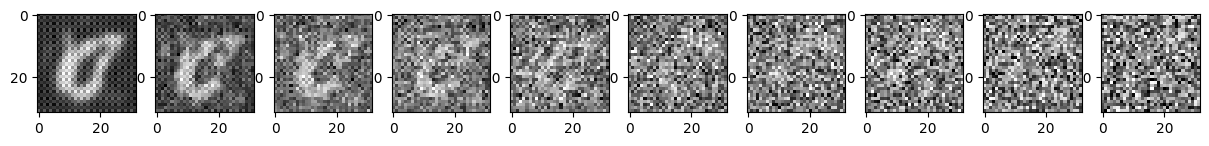

Epoch 10 | step 000 Loss: 0.10370130836963654 Creating with Label : 5


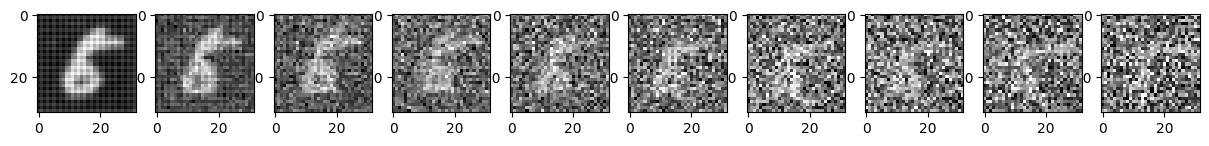

Epoch 15 | step 000 Loss: 0.08684386312961578 Creating with Label : 5


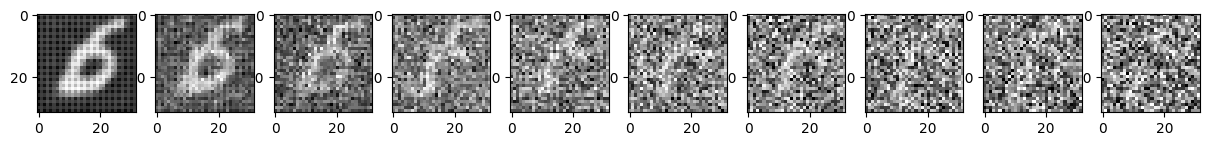

Epoch 20 | step 000 Loss: 0.08941146731376648 Creating with Label : 6


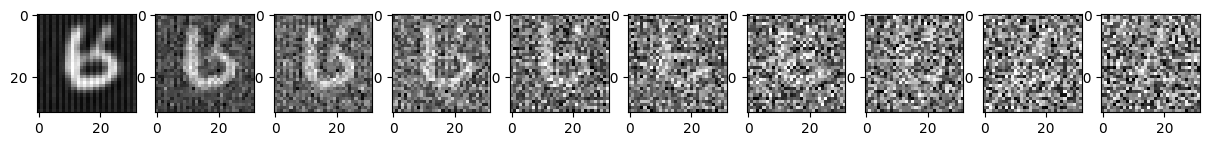

Epoch 25 | step 000 Loss: 0.07898697257041931 Creating with Label : 7


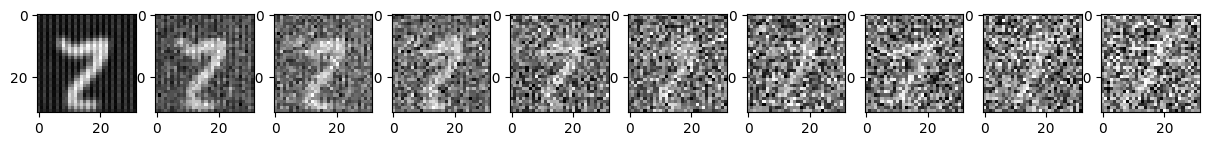

Epoch 30 | step 000 Loss: 0.0856153815984726 Creating with Label : 5


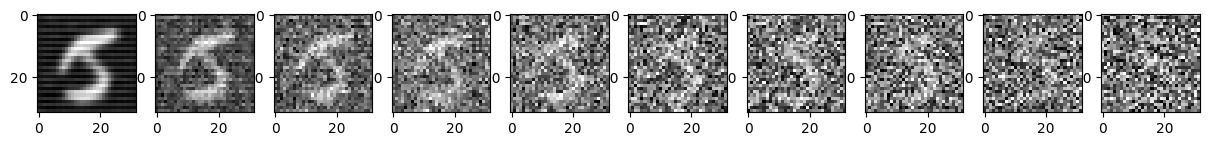

Epoch 35 | step 000 Loss: 0.07922166585922241 Creating with Label : 0


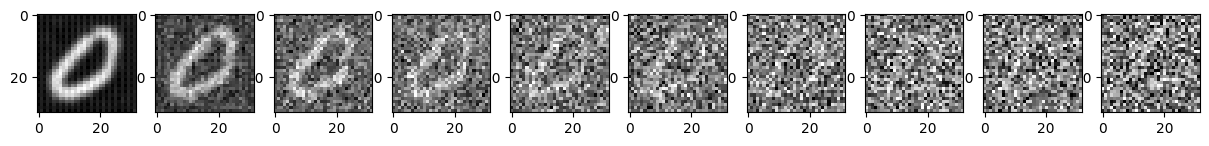

Epoch 40 | step 000 Loss: 0.07761552929878235 Creating with Label : 7


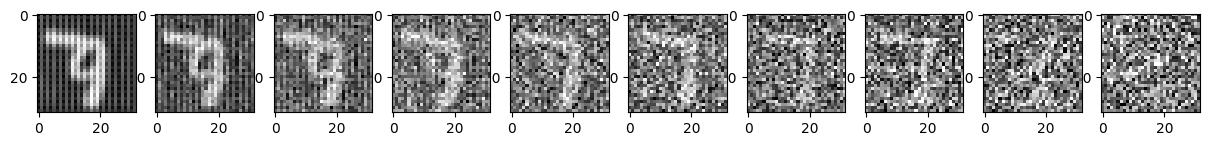

Epoch 45 | step 000 Loss: 0.07681899517774582 Creating with Label : 9


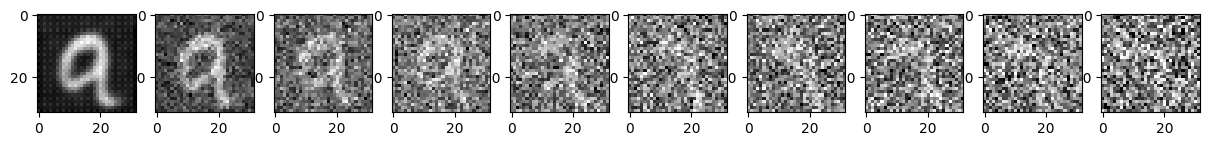

Epoch 50 | step 000 Loss: 0.08345064520835876 Creating with Label : 6


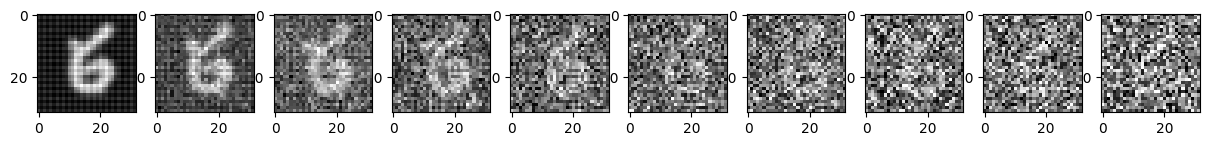

Epoch 55 | step 000 Loss: 0.07767549157142639 Creating with Label : 6


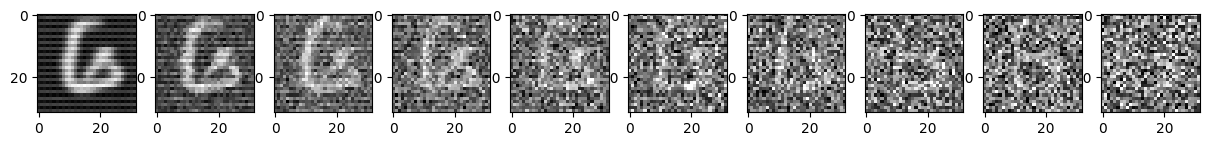

Epoch 60 | step 000 Loss: 0.08037759363651276 Creating with Label : 3


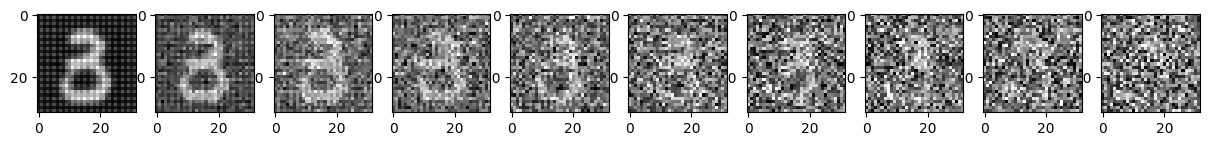

Epoch 65 | step 000 Loss: 0.07488779723644257 Creating with Label : 2


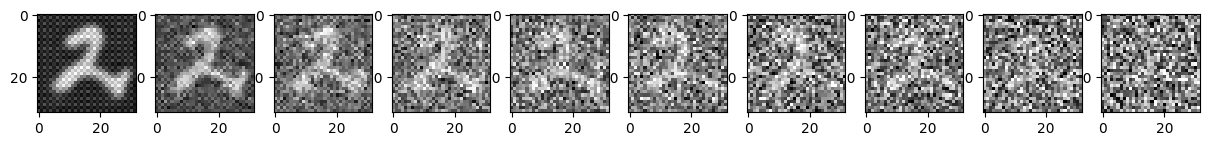

Epoch 70 | step 000 Loss: 0.06864628940820694 Creating with Label : 1


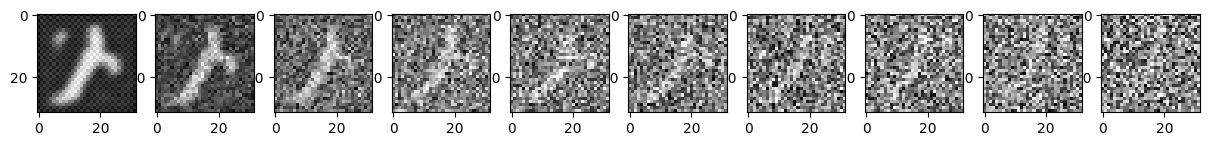

Epoch 75 | step 000 Loss: 0.07923869788646698 Creating with Label : 1


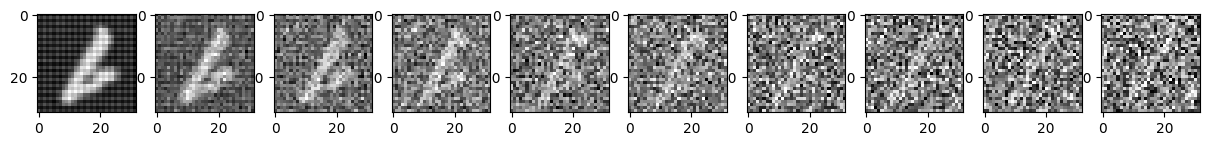

Epoch 80 | step 000 Loss: 0.07139632105827332 Creating with Label : 0


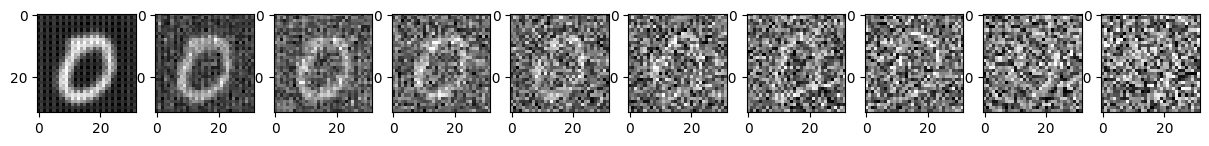

Epoch 85 | step 000 Loss: 0.07004491984844208 Creating with Label : 0


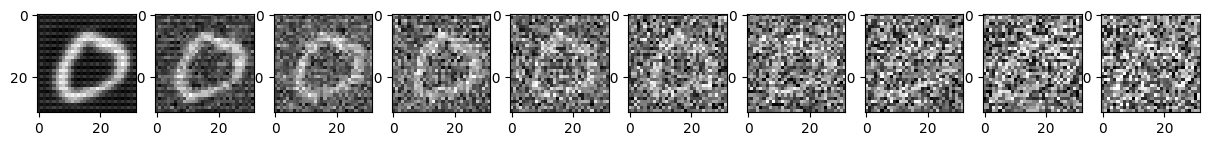

Epoch 90 | step 000 Loss: 0.07357780635356903 Creating with Label : 0


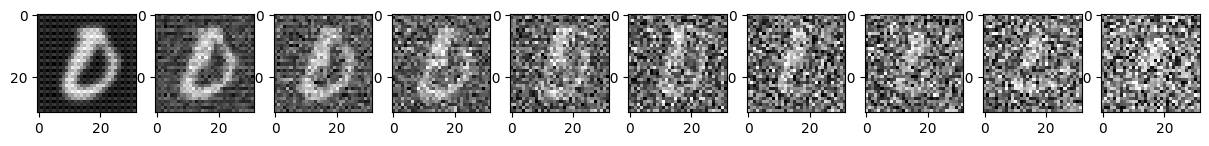

Epoch 95 | step 000 Loss: 0.06701160967350006 Creating with Label : 7


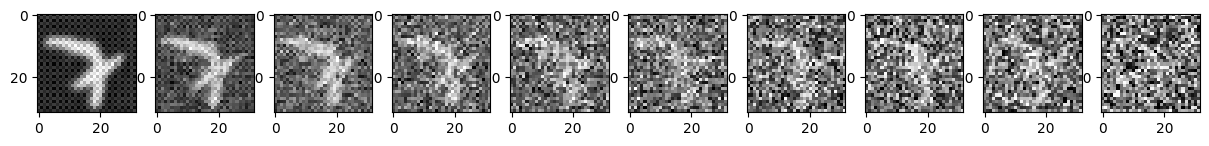

In [44]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, (img_batch, lbl_batch) in enumerate(dataloader):
      optimizer.zero_grad()

      if np.random.random() < 0.1: lbl_batch = None
      else: lbl_batch = lbl_batch.to(device)

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, img_batch, t, lbl_batch)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        label = torch.randint(0, 10, (1,)).to(device)
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} Creating with Label : {label.item()}")
        sample_plot_image(label)

In [45]:
torch.save(model, 'diffusion_fixed_v1')

Epoch 0 | step 000 Loss: 0.07587049156427383 Creating with Label : 1


/tmp/ipykernel_71272/3398544776.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


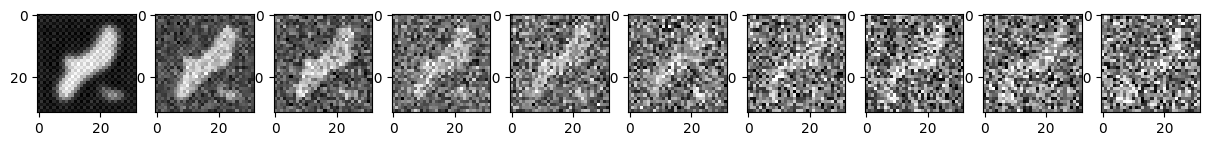

Epoch 5 | step 000 Loss: 0.06726296246051788 Creating with Label : 6


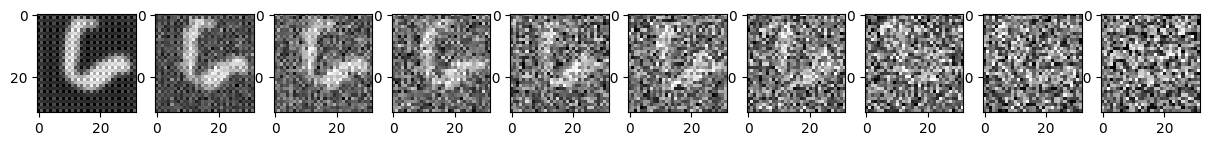

Epoch 10 | step 000 Loss: 0.0715988278388977 Creating with Label : 5


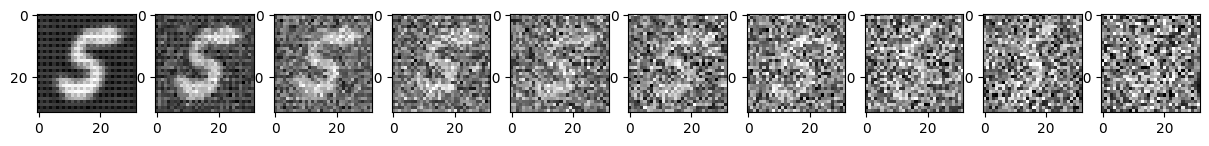

Epoch 15 | step 000 Loss: 0.07615542411804199 Creating with Label : 1


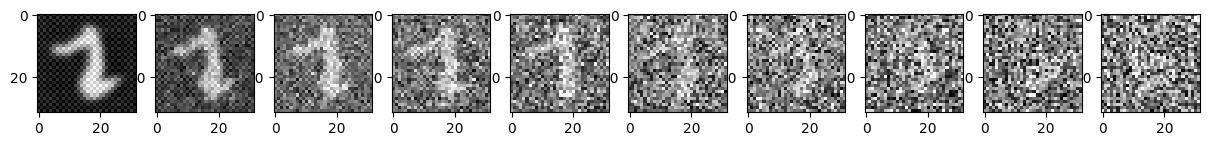

Epoch 20 | step 000 Loss: 0.07737790048122406 Creating with Label : 1


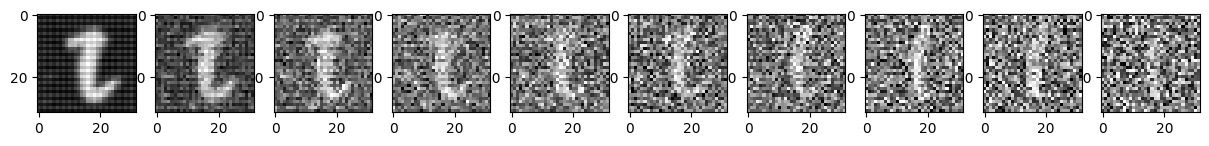

Epoch 25 | step 000 Loss: 0.06613805890083313 Creating with Label : 8


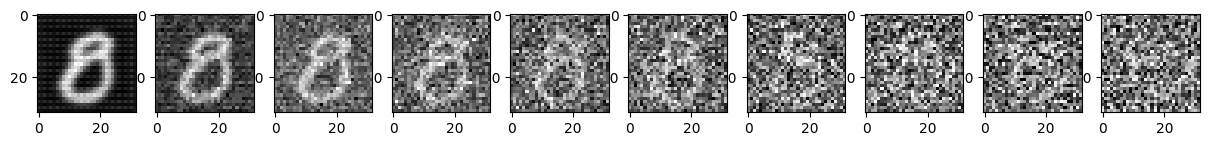

Epoch 30 | step 000 Loss: 0.06915877759456635 Creating with Label : 4


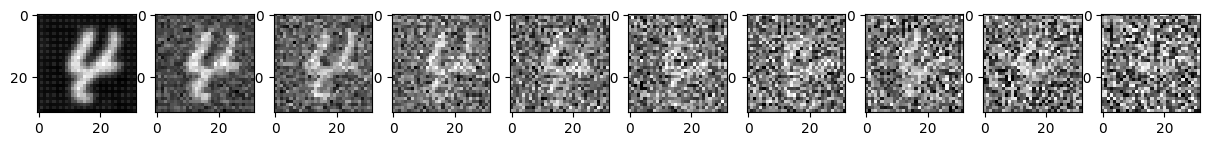

Epoch 35 | step 000 Loss: 0.07871565222740173 Creating with Label : 2


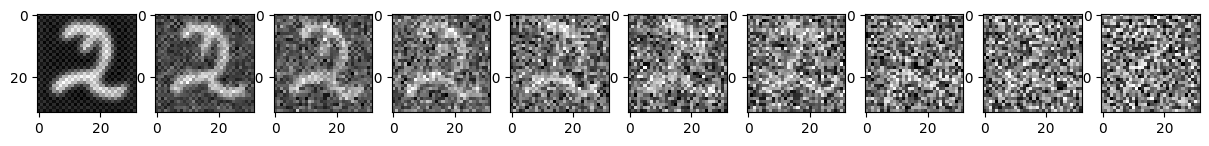

Epoch 40 | step 000 Loss: 0.06785066425800323 Creating with Label : 7


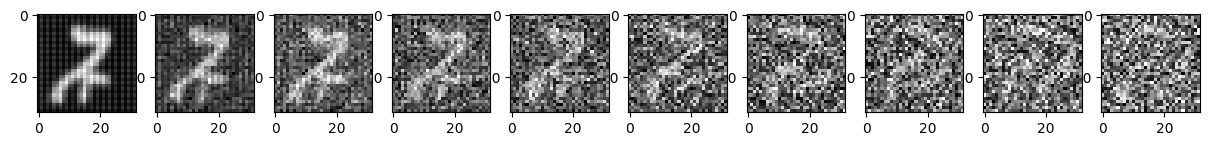

Epoch 45 | step 000 Loss: 0.06660676002502441 Creating with Label : 6


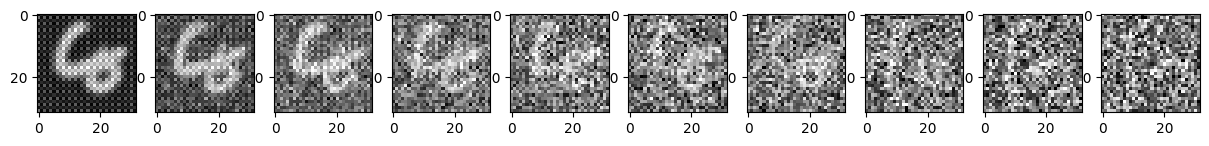

Epoch 50 | step 000 Loss: 0.06727872788906097 Creating with Label : 2


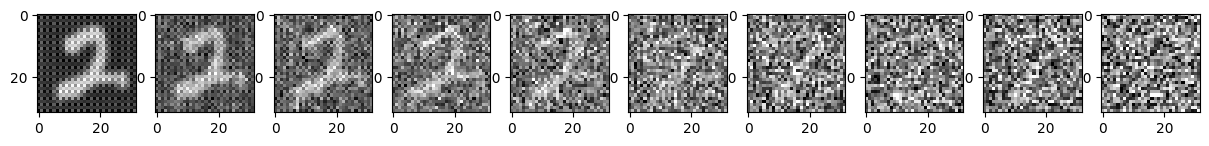

Epoch 55 | step 000 Loss: 0.06393080204725266 Creating with Label : 6


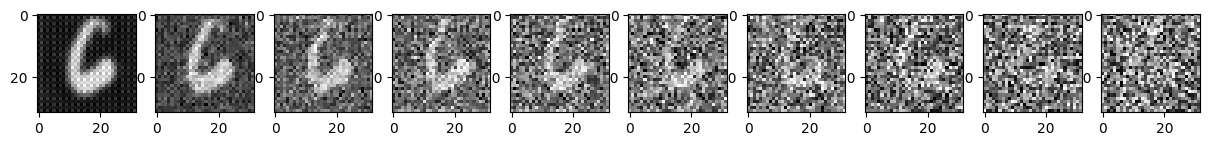

Epoch 60 | step 000 Loss: 0.06408669799566269 Creating with Label : 7


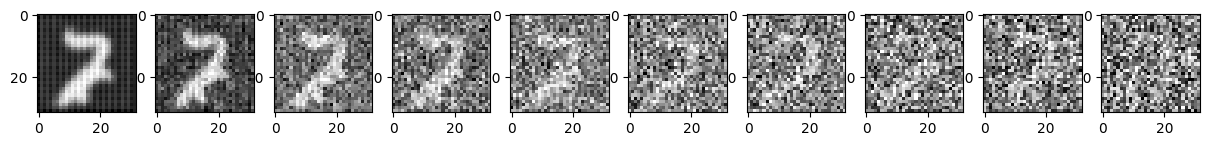

Epoch 65 | step 000 Loss: 0.06555943191051483 Creating with Label : 8


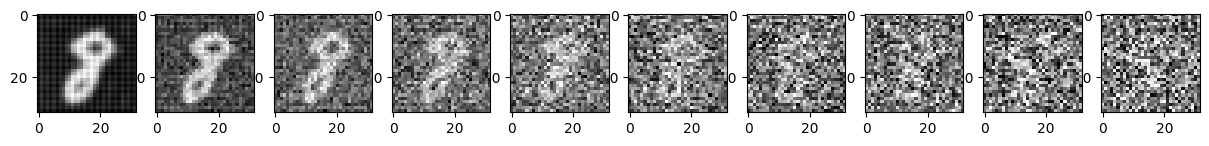

Epoch 70 | step 000 Loss: 0.07154561579227448 Creating with Label : 3


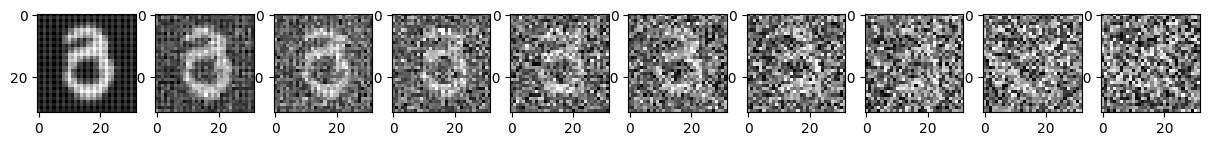

Epoch 75 | step 000 Loss: 0.06958351284265518 Creating with Label : 5


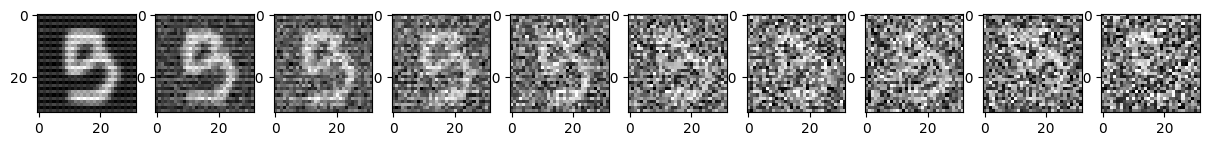

Epoch 80 | step 000 Loss: 0.06277818232774734 Creating with Label : 3


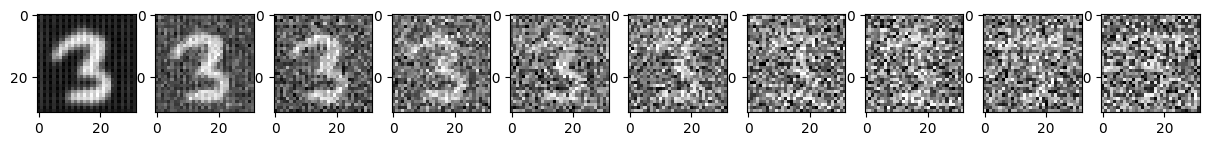

Epoch 85 | step 000 Loss: 0.06925296783447266 Creating with Label : 7


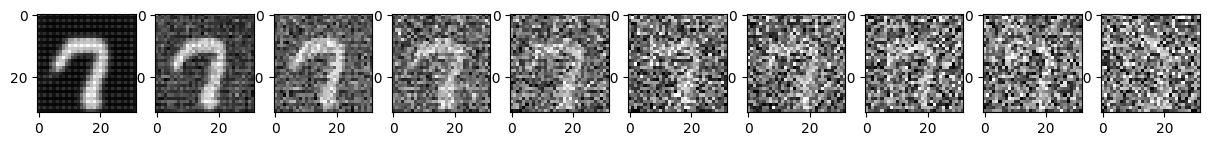

Epoch 90 | step 000 Loss: 0.06837789714336395 Creating with Label : 1


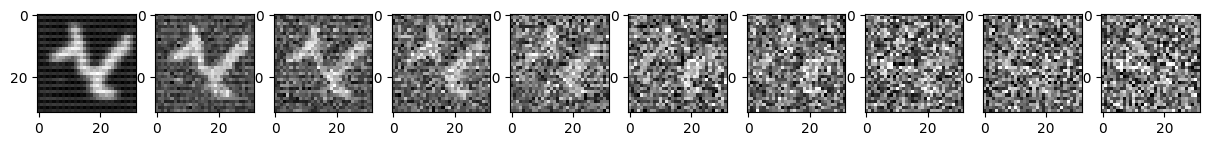

Epoch 95 | step 000 Loss: 0.06833034753799438 Creating with Label : 5


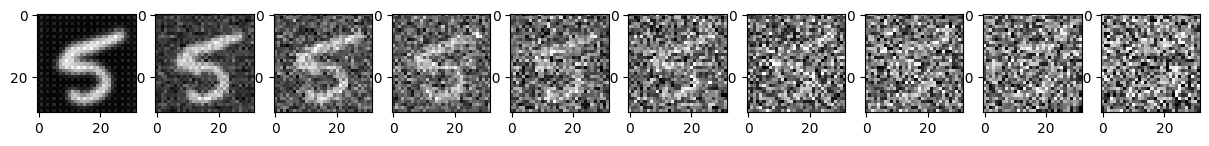

In [46]:
for epoch in range(epochs):
    for step, (img_batch, lbl_batch) in enumerate(dataloader):
      optimizer.zero_grad()

      if np.random.random() < 0.1: lbl_batch = None
      else: lbl_batch = lbl_batch.to(device)

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, img_batch, t, lbl_batch)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        label = torch.randint(0, 10, (1,)).to(device)
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} Creating with Label : {label.item()}")
        sample_plot_image(label)

In [48]:
torch.save(model, 'diffusion_fixed_v2')

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.load('diffusion_v2')
model.to(device);

/tmp/ipykernel_71272/453682508.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


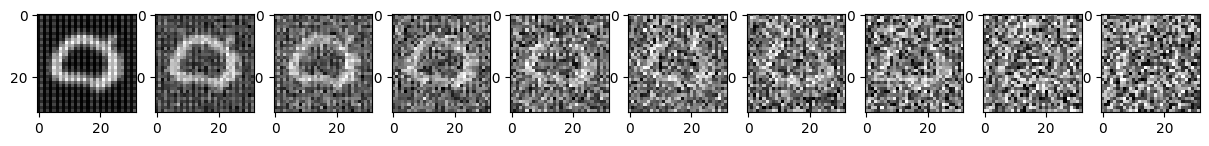

In [53]:
sample_plot_image(torch.tensor([6]).to(device), cfg_scale=-1)

/tmp/ipykernel_71272/453682508.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


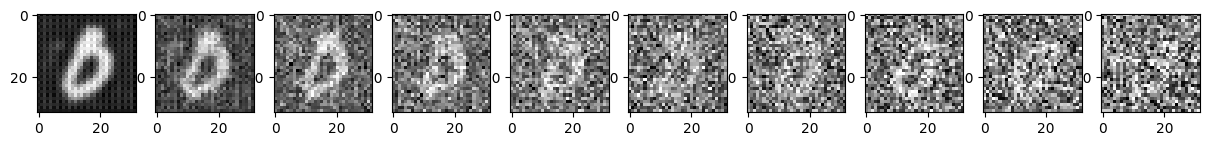

In [54]:
sample_plot_image(torch.tensor([6]).to(device), cfg_scale=0)

/tmp/ipykernel_71272/453682508.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


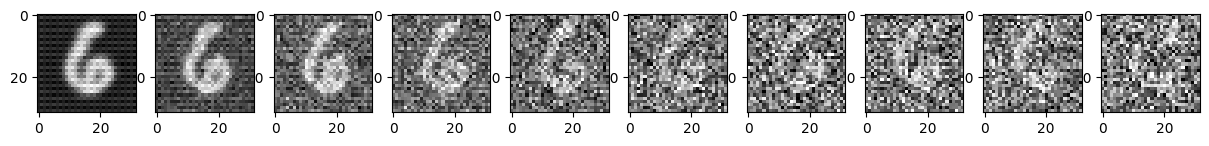

In [55]:
sample_plot_image(torch.tensor([6]).to(device), cfg_scale=5)

/tmp/ipykernel_71272/453682508.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


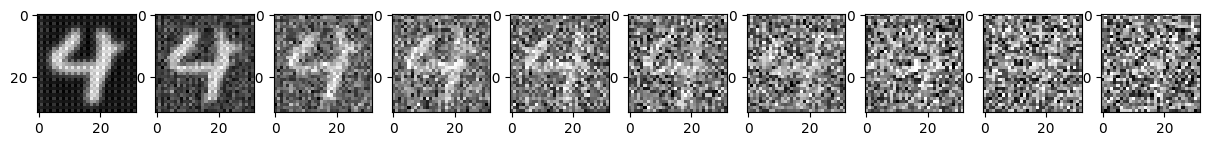

In [56]:
sample_plot_image(torch.tensor([4]).to(device), cfg_scale=2)

/tmp/ipykernel_71272/453682508.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


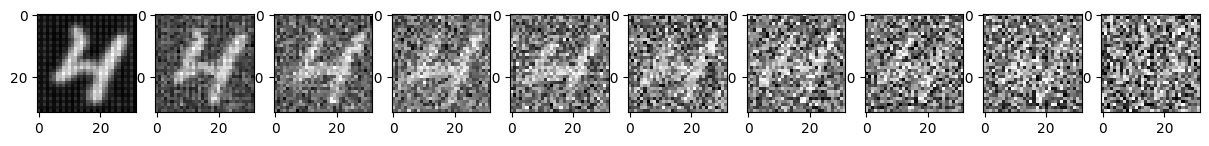

In [57]:
sample_plot_image(torch.tensor([4]).to(device), cfg_scale=10)

/tmp/ipykernel_71272/453682508.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


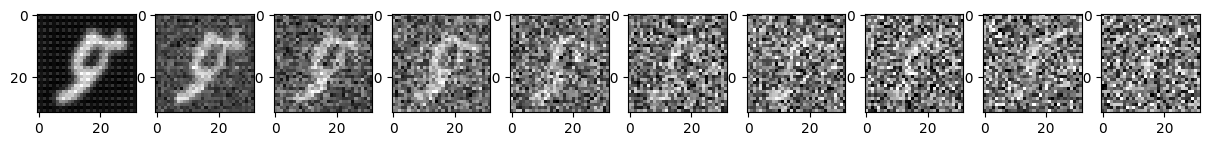

In [58]:
sample_plot_image(torch.tensor([5]).to(device), cfg_scale=0)

/tmp/ipykernel_71272/453682508.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


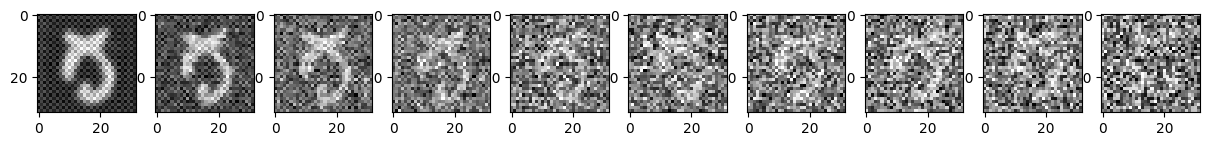

In [59]:
sample_plot_image(torch.tensor([5]).to(device), cfg_scale=7)